In [1]:
% matplotlib notebook
import json
from utils import *

import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter
from scipy.signal import wiener
import math
import scipy

from kalman_filtering import oneIterPowerKalmanFilter


/Users/stranot/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
data_file = 'val_err_wo_lr_decay.json'
# data_file = 'val_err.json'
with open(data_file) as f:
    val_acc = json.load(f)

val_err = 1 - np.array(val_acc)
num_epochs_between_eval = 20
min_delta = 1e-3
patience = 8
# steps = (np.arange(len(val_err)) + 1)*num_epochs_between_eval

smooth_win_size = 50
whole_smoothed_val_err = smooth_by_linear_filter(val_err, smooth_win_size)

In [3]:
minEpoch = (np.argmin(whole_smoothed_val_err)+1)*20
print(minEpoch, np.min(whole_smoothed_val_err), len(whole_smoothed_val_err))
earlyStoppingStep = early_stopping_step(val_err, min_delta, patience, smooth_win_size, num_epochs_between_eval )
print(earlyStoppingStep, whole_smoothed_val_err[earlyStoppingStep//20+1])

9180 0.33029411820804366 507
3520 0.37988235260926045


<IPython.core.display.Javascript object>


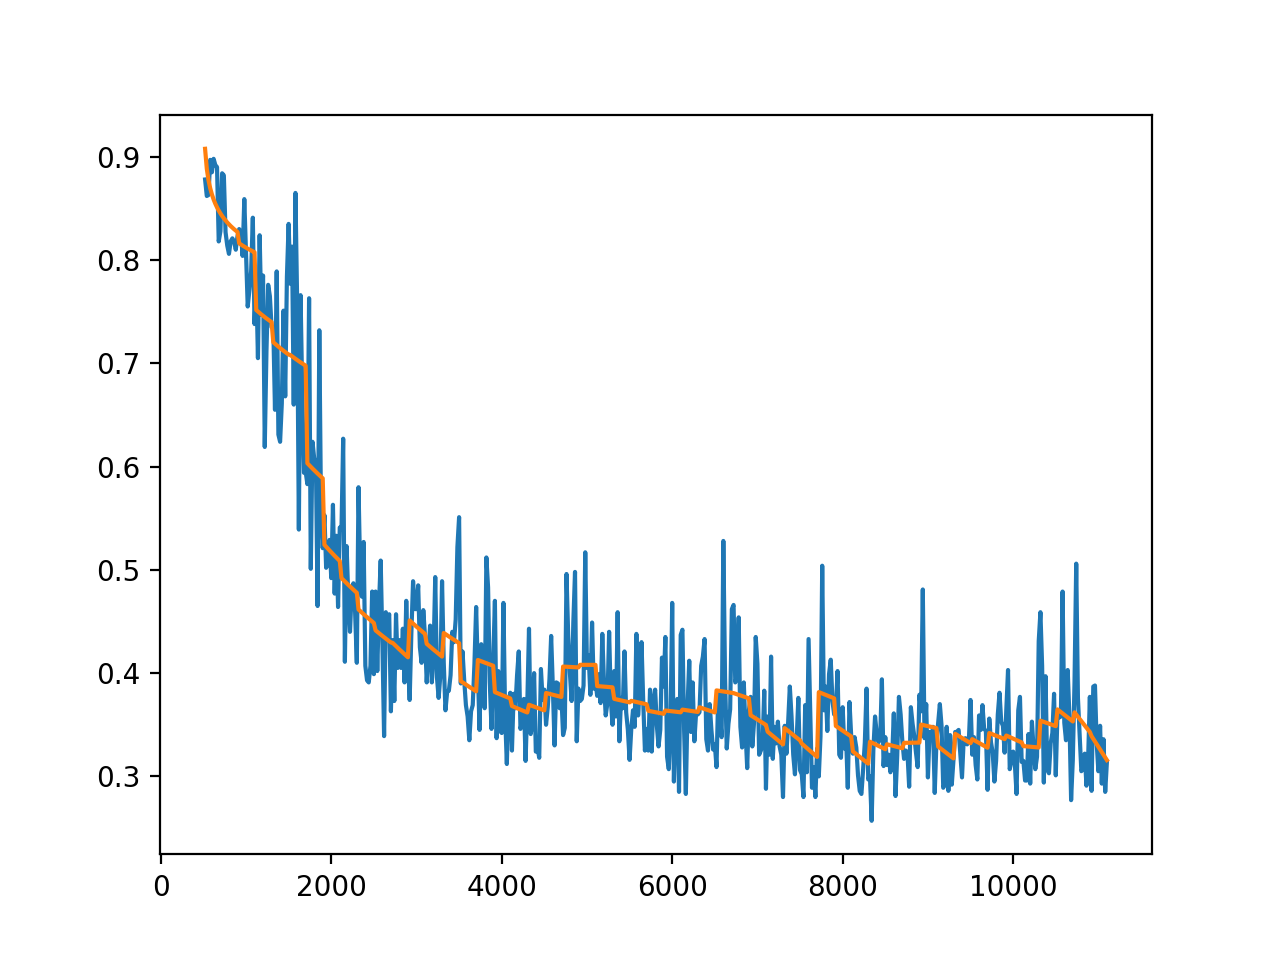

In [6]:
num_outliers = 25 # delete some outliers
smoothed_val_err = whole_smoothed_val_err[num_outliers:]

start_point = 20
pred_win_size = 100
left_tail_size = 0
period = 10
pred_min_delta = min_delta
wtype = 'linear'
num_samples = 1000

var_ud = 1e-3

input_data = []
for i, d in enumerate(val_err):
    if i >= pred_win_size:
        input_data.pop(0) 
    input_data.append(d)
    
    if i == start_point-1:
        KF = oneIterPowerKalmanFilter(num_epochs_between_eval,
                                 pred_win_size,
                                 period,
                                 input_data,
                                  var_ud
                             )
    
    if i >= start_point and (i-start_point+1)%period == 0:
#         print(len(input_data))
        KF.oneIterKF(np.array(input_data))
#         print(KF.M_est)
#     signals = np.concatenate([signals, KF.sq_est])

# print(KF.all_estimates)

plt.figure()
KF_steps = (np.arange(len(KF.all_estimates)) + 1 + num_outliers)*num_epochs_between_eval
plt.plot(KF_steps, KF.all_original_data)
plt.plot(KF_steps, KF.all_estimates)
    
    
    

In [9]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


def indicatorSimulation(data, 
                        smooth_win_size,
                         num_epochs_between_eval, 
                         min_delta, patience, 
                         pred_win_size, 
                         period,
                         start_point=100, 
                        num_samples=1000,
                        upper_limit=2e4):
    upper_lim_points = upper_limit // num_epochs_between_eval
    
    def _addingNoiseBootstrapping(predicts, R, shift):
#         print(R)
        period = R.shape[0]
        noise_sample_size = len(predicts) // period
        residual = len(predicts) % period
#         print(residual)
        truncated_R = R[:residual,:residual]

        stopping_epochs = []
        for i in range(num_samples):
            noise = np.random.multivariate_normal(np.zeros(period), R, noise_sample_size).reshape((1,-1))[0]
            noise = np.concatenate([noise, np.random.multivariate_normal(np.zeros(residual), truncated_R)])
            measurement = predicts + noise
            smoothed_measurement = smooth_by_linear_filter(measurement, smooth_win_size)
            try:
                stopping_epochs.append(
                    early_stopping_step(measurement, min_delta, patience, smooth_win_size, num_epochs_between_eval) + shift)
            except:
                continue
        return np.mean(stopping_epochs), np.array(stopping_epochs), measurement, smoothed_measurement
    
    epoch_preds = []
    samples = []
    CIs = []
    
    KF_input_queue = []
    for i, d in enumerate(data):
        if i >= pred_win_size:
            KF_input_queue.pop(0) 
        KF_input_queue.append(d)

        if i == start_point-1:
            print(KF_input_queue, len(KF_input_queue))
            KF = oneIterPowerKalmanFilter(num_epochs_between_eval,
                                     pred_win_size,
                                     period,
                                     KF_input_queue,
                                      var_ud
                                 )

        if i >= start_point and (i-start_point+1)%period == 0:
            shift = (i+1)*num_epochs_between_eval
            print('Global Step: {}'.format(shift))
            KF.oneIterKF(np.array(KF_input_queue))
            predicts, est_pred = KF.predictionByCurrent(int(upper_lim_points - len(KF.all_estimates)))
            epoch_pred, stopping_epochs, _, sample_measurement = _addingNoiseBootstrapping(predicts, KF.R, shift)
            _, CI_left, CI_right = mean_confidence_interval(stopping_epochs)
        
            epoch_preds.append(epoch_pred)
            CIs.append((CI_left, CI_right))
            samples.append(np.concatenate([KF.all_estimates, sample_measurement]))
            
            print('Predicted early stopping epoch: {0}, [{1},{2}]'.format(epoch_pred, CI_left, CI_right))
        
    return epoch_preds, CIs, samples
            
def CIs2errs(CIs):
    errs = []
    for ci in CIs:
        errs.append((ci[1]-ci[0])/2)
    
    return np.array(errs)           
            
    

[0.8779999986290932, 0.8620000034570694, 0.8630000054836273, 0.8969999998807907, 0.8849999979138374, 0.8980000019073486, 0.8919999971985817, 0.8900000005960464, 0.818000003695488, 0.8279999941587448, 0.8840000033378601, 0.8819999992847443, 0.8270000070333481, 0.8139999955892563, 0.8059999942779541, 0.818000003695488, 0.8209999948740005, 0.818000003695488, 0.8100000023841858, 0.8229999989271164] 20
Global Step: 800


/Users/stranot/qfdong/research/Early_stopping/simulate_online_regression/utils.py:75: RuntimeWarning: invalid value encountered in log
  b, a = np.linalg.lstsq(A, np.log(y)*weights, rcond=-1)[0]


Predicted early stopping epoch: 1205.44, [1174.0644458824843,1236.8155541175158]
Global Step: 1200
Predicted early stopping epoch: 9129.16, [8713.500766421828,9544.819233578171]
Global Step: 1600
Predicted early stopping epoch: 9913.3, [9550.645827910246,10275.954172089752]
Global Step: 2000
Predicted early stopping epoch: 9477.08, [9173.823136194324,9780.336863805676]
Global Step: 2400
Predicted early stopping epoch: 9332.38, [9091.258420183825,9573.501579816173]
Global Step: 2800
Predicted early stopping epoch: 7798.7, [7556.076813818467,8041.323186181533]
Global Step: 3200
Predicted early stopping epoch: 7476.4, [7223.379858883736,7729.420141116263]
Global Step: 3600
Predicted early stopping epoch: 4745.34, [4687.791167893142,4802.888832106858]
Global Step: 4000
Predicted early stopping epoch: 5609.44, [5531.635506653416,5687.244493346583]
Global Step: 4400
Predicted early stopping epoch: 8028.1, [7935.028822111842,8121.171177888159]
Global Step: 4800
Predicted early stopping epoch:

<IPython.core.display.Javascript object>


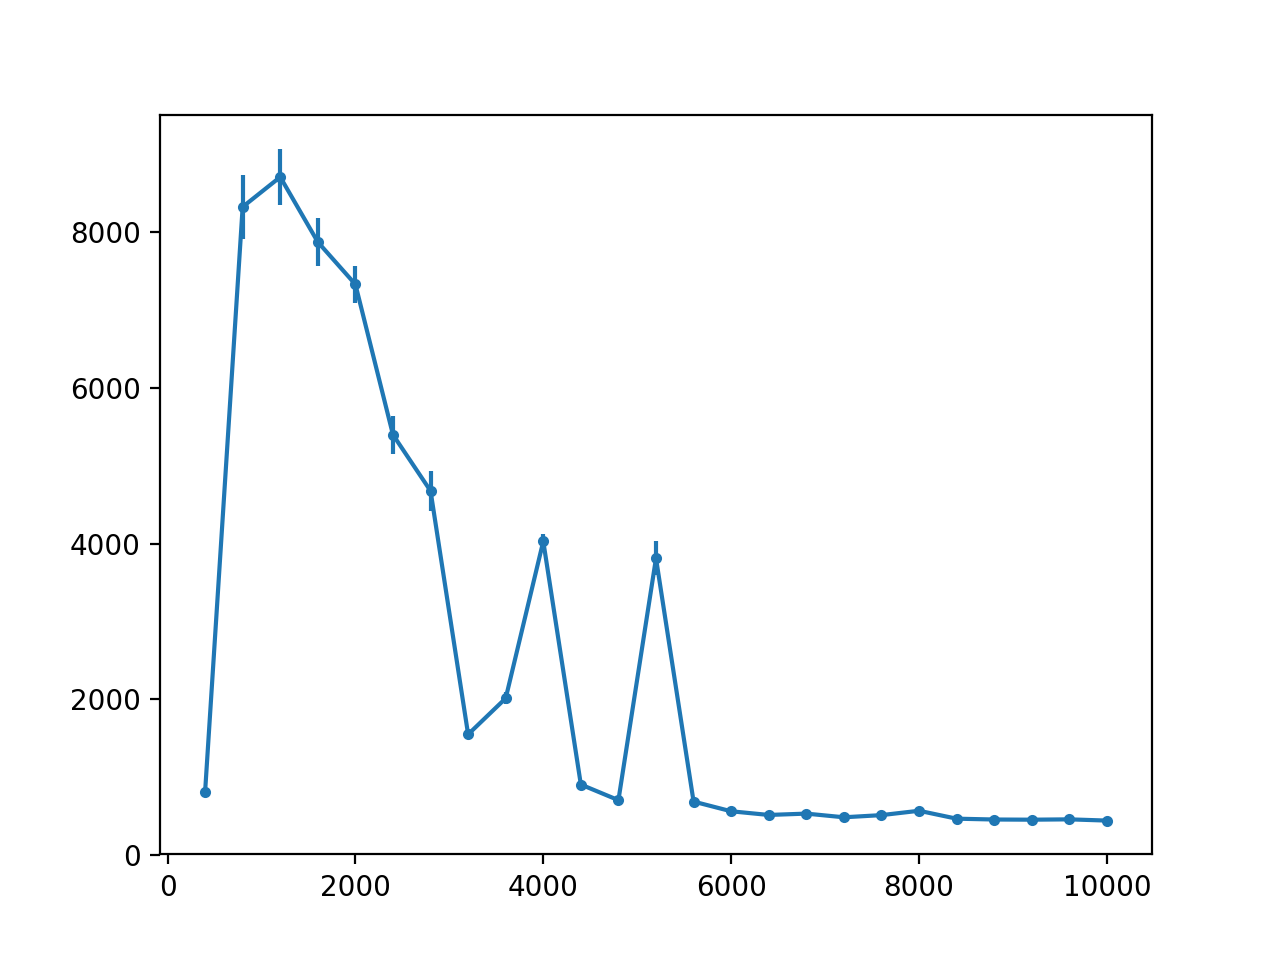

<Container object of 3 artists>

In [10]:
pred_win_size = 100
left_tail_size = 0
period = 20
start_point = 20
pred_min_delta = min_delta
wtype = 'linear'
num_samples = 1000

# it's acually equivalent to setting no upper limit because 2e5 is larger enough
upper_limit = 2e5

# set a effective upper limit
# upper_limit_bias = 80
# upper_limit = (len(val_err) + upper_limit_bias)*num_epochs_between_eval

preds, CIs, samples = indicatorSimulation(
                                    val_err,
                                    smooth_win_size,
                                     num_epochs_between_eval, 
                                     pred_min_delta,
                                     patience,
                                    pred_win_size = pred_win_size,
                                    period = period,
                                    start_point = start_point,
                                    num_samples=1000,
                                    upper_limit=upper_limit)
print(len(preds))

errs = CIs2errs(CIs)

plt.figure()
x = (start_point+(np.arange(len(preds)))*period)*num_epochs_between_eval
plt.errorbar(x, preds-x, errs, fmt='.-')

<IPython.core.display.Javascript object>


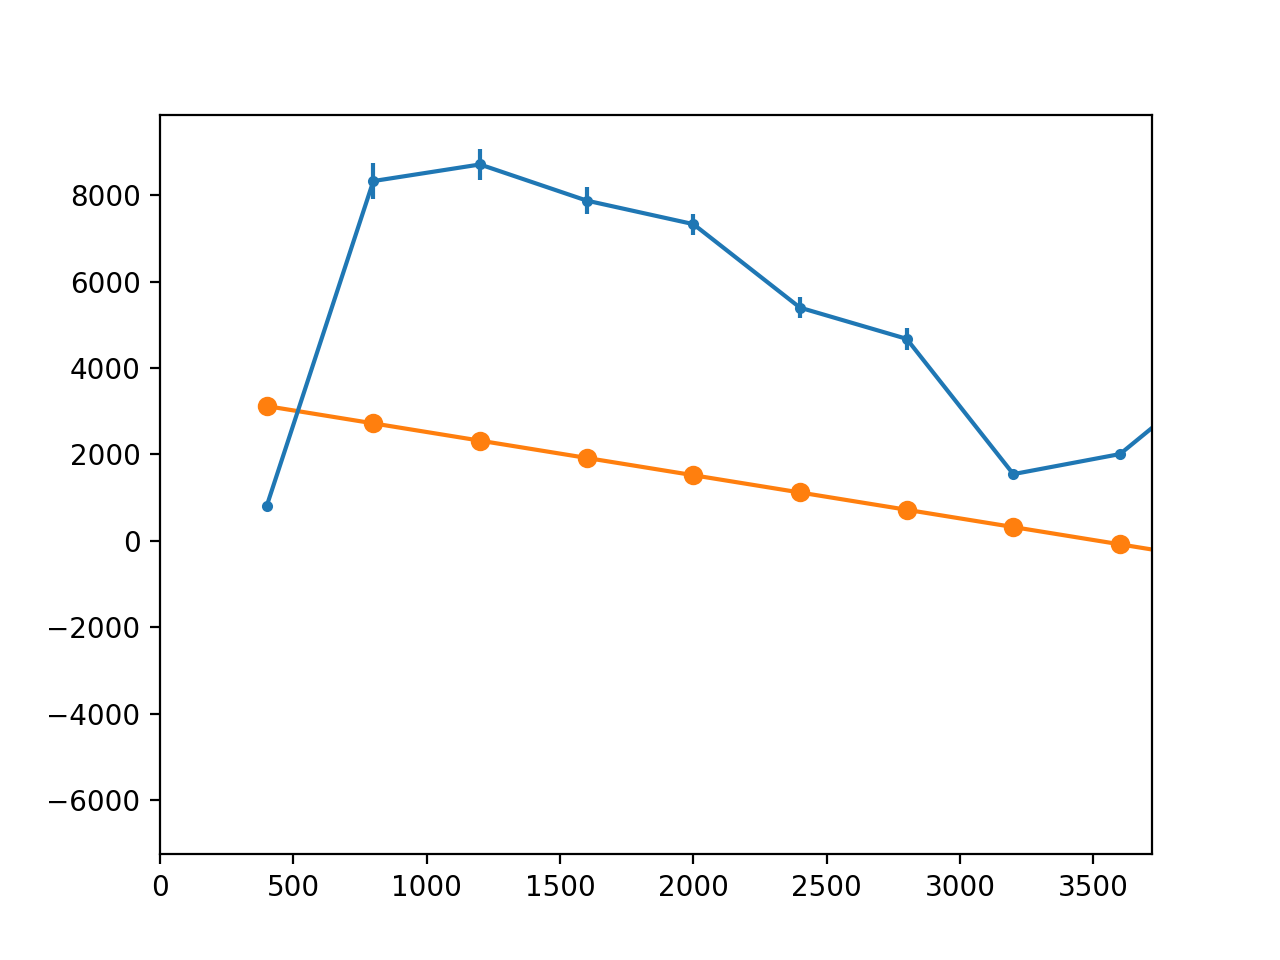

(0, 3720)

In [11]:
plt.figure()
x = (start_point+(np.arange(len(preds)))*period)*num_epochs_between_eval
plt.errorbar(x, preds-x, errs, fmt='.-')
plt.plot(x, earlyStoppingStep-x,'-o')
plt.xlim(0,earlyStoppingStep+200)

In [ ]:
# print(coeffs)
fig = plt.figure(figsize=[10, 8])
# ax = plt.subplot()
# ax.set_ylim(0, 1.5)
# ax.plot(steps, val_err)

co = 0
step_size = 4
for i in range(0,len(samples),step_size):
    co += 1
    ax = plt.subplot(4,4, co)
    ax.set_ylim(0, 1.5)
#     ax.plot(steps, val_err)
    ax.plot(KF_steps, KF.all_original_data)
    x = np.arange(1,len(samples[i])+1)*num_epochs_between_eval
#     ax.plot(x,smoothed_samples[i])
    ax.plot(x,samples[i])
#     ax.plot(steps+shifts[i], coeffs[i][0]*np.power(steps,coeffs[i][1]))
    e = (start_point + i*period)*num_epochs_between_eval
    s = max(0, ((start_point+i*period) - pred_win_size)*num_epochs_between_eval)
    ax.set_title('Sampled epochs:\n [{}, {}]'.format(s,e))
    ax.set_xlim(-500,11200)
    
fig.tight_layout()   